<a href="https://colab.research.google.com/github/taechanha/inverseDesignMetaMatl/blob/main/%5Br%5D_Adj_%26_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################

import numpy as np
import matplotlib.pyplot as plt

f = open("/content/dataset_2.txt", 'r')
data = []
length = 0
for i in f:
  new = []
  new.append(i)
  data.append(new)

  # length of dataset
  length += 1

f.close()

# create dataset from data
dataset = []
for i in range(length):
  new = []
  for j in data[i][0].split(','):
    new.append(float(j))
  dataset.append(new)


# trim out label from dataset
# Ex Ey Ez
label = []
new = []
for line in dataset:
  tmp = []
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.reverse()
  label.append(tmp)

print("label.shape: ", np.array(label).shape)


# create edge_index
edge_mat = np.zeros(shape=(27,27))
edge_index = []

for e in range(len(dataset)):
  for i in range(0, 27):
    for j in range(i+1, 27):
      edge_mat[i][j] = dataset[e].pop(0)
  edge_index.append(edge_mat + edge_mat.T)


# whole dataset to Tensor & train/test split
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

edge_index = torch.FloatTensor(edge_index)
label = torch.FloatTensor(label)

split = int(length * 0.8)

x_train = edge_index[:split]
y_train = label[:split]
x_val = edge_index[split:]
y_val = label[split:]

print("x_train, y_train, x_val shape: ", x_train.shape, y_train.shape, x_val.shape)

# create torch dataset
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, label, dataset, transform=None, target_transform=None):
        self.labels = label
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

# create DataLoader
from torch.utils.data import DataLoader

training_data   = CustomDataset(label=y_train, dataset=x_train)
test_data       = CustomDataset(label=y_val, dataset=x_val)
train_loader    = DataLoader(training_data, batch_size=4, shuffle=True)
test_loader     = DataLoader(test_data, batch_size=4, shuffle=False)

label.shape:  (2000, 3)
x_train, y_train, x_val shape:  torch.Size([1600, 27, 27]) torch.Size([1600, 3]) torch.Size([400, 27, 27])


In [11]:
epochs = 100

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 3)

        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        # x = F.leaky_relu(x)
        # x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc3(x)
        # x = F.leaky_relu(x)
        # x = self.fc4(x)
        # x = F.leaky_relu(x)
        # x = self.fc5(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=3, bias=True)
)


In [48]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

2190

In [15]:
def train(model, train_losses, epoch):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.cuda().float(), y.cuda()
        optimizer.zero_grad()
        o = model(x)
        loss = loss_function(o, y)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print('====> Epoch: {} loss: {:.4f}'.format(e, train_loss / len(train_loader)))
    train_losses.append(train_loss / len(train_loader))

def test(model, val_losses):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o = model(x)
            loss = loss_function(o, y)
            
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))
    val_losses.append(test_loss / len(test_loader))

def test_pred(model):
    y_pred = []
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o = model(x)
            y_pred.append(o)

            loss = loss_function(o, y)
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

    return y_pred

In [50]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.MSELoss()
epochs = 500

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 116.9155
====> Test set loss: 110.5995
====> Epoch: 2 loss: 106.7596
====> Test set loss: 100.9539
====> Epoch: 3 loss: 97.4907
====> Test set loss: 92.1510
====> Epoch: 4 loss: 89.0011
====> Test set loss: 84.0994
====> Epoch: 5 loss: 81.2463
====> Test set loss: 76.7608
====> Epoch: 6 loss: 74.1801
====> Test set loss: 70.0423
====> Epoch: 7 loss: 67.7673
====> Test set loss: 63.9809
====> Epoch: 8 loss: 61.9523
====> Test set loss: 58.4803
====> Epoch: 9 loss: 56.7057
====> Test set loss: 53.5061
====> Epoch: 10 loss: 51.9814
====> Test set loss: 49.0696
====> Epoch: 11 loss: 47.7658
====> Test set loss: 45.1286
====> Epoch: 12 loss: 44.0204
====> Test set loss: 41.6122
====> Epoch: 13 loss: 40.7088
====> Test set loss: 38.5228
====> Epoch: 14 loss: 37.7894
====> Test set loss: 35.7932
====> Epoch: 15 loss: 35.2459
====> Test set loss: 33.4295
====> Epoch: 16 loss: 33.0457
====> Test set loss: 31.3920
====> Epoch: 17 loss: 31.1545
====> Test set loss: 29.6604
==

In [51]:
y1 = y_pred

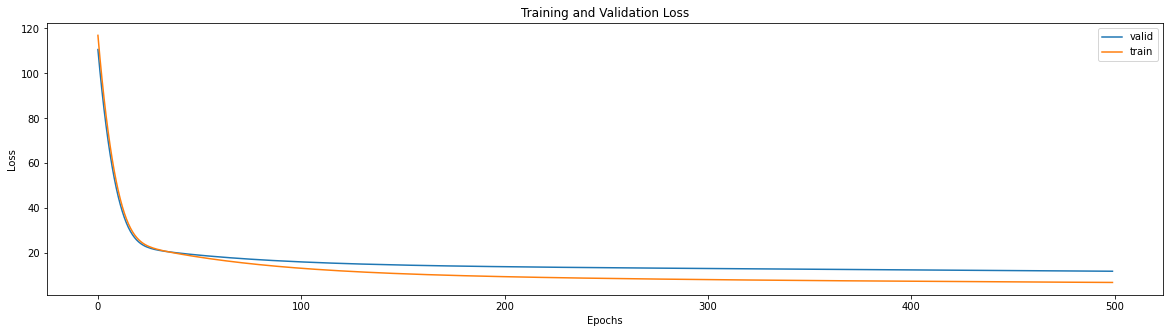

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [53]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 3.3363


In [24]:
#

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 6)
        self.fc2 = nn.Linear(6, 3)

        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc3(x)
        # x = F.leaky_relu(x)
        # x = self.fc4(x)
        # x = F.leaky_relu(x)
        # x = self.fc5(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=3, bias=True)
)


In [59]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

4401

In [60]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()
epochs = 374

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 125.6342
====> Test set loss: 123.4495
====> Epoch: 2 loss: 122.4277
====> Test set loss: 119.7642
====> Epoch: 3 loss: 117.9503
====> Test set loss: 114.5056
====> Epoch: 4 loss: 111.9588
====> Test set loss: 107.8023
====> Epoch: 5 loss: 104.4401
====> Test set loss: 99.3194
====> Epoch: 6 loss: 95.0937
====> Test set loss: 89.2300
====> Epoch: 7 loss: 84.5811
====> Test set loss: 78.4780
====> Epoch: 8 loss: 73.9604
====> Test set loss: 68.0834
====> Epoch: 9 loss: 64.0086
====> Test set loss: 58.6566
====> Epoch: 10 loss: 55.1662
====> Test set loss: 50.4672
====> Epoch: 11 loss: 47.6541
====> Test set loss: 43.5740
====> Epoch: 12 loss: 41.5151
====> Test set loss: 38.1249
====> Epoch: 13 loss: 36.6122
====> Test set loss: 33.6825
====> Epoch: 14 loss: 32.4703
====> Test set loss: 29.8127
====> Epoch: 15 loss: 28.9340
====> Test set loss: 26.7783
====> Epoch: 16 loss: 26.3514
====> Test set loss: 24.7123
====> Epoch: 17 loss: 24.6318
====> Test set loss: 23.42

In [61]:
y2 = y_pred

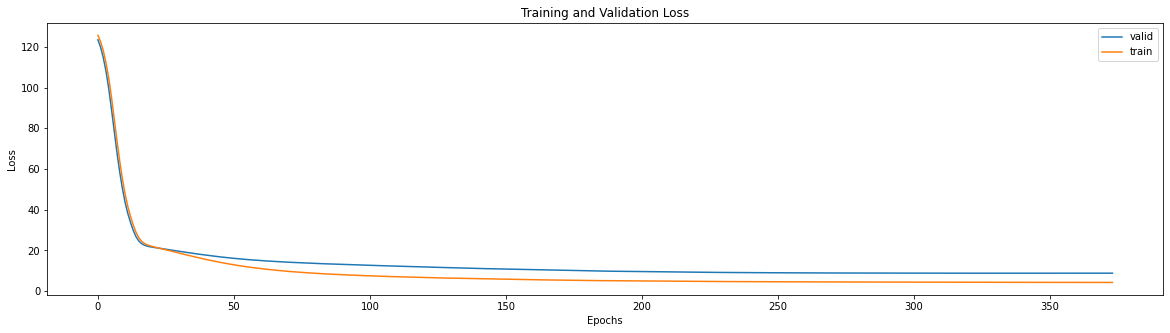

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [63]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 2.8969


In [ ]:
#

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 364)
        self.fc2 = nn.Linear(364, 182)
        self.fc3 = nn.Linear(182, 3)

        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.leaky_relu(x)
        # x = self.fc4(x)
        # x = F.leaky_relu(x)
        # x = self.fc5(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=364, bias=True)
  (fc2): Linear(in_features=364, out_features=182, bias=True)
  (fc3): Linear(in_features=182, out_features=3, bias=True)
)


In [27]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

332699

In [28]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()
epochs = 500

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 46.3396
====> Test set loss: 24.4722
====> Epoch: 2 loss: 23.2851
====> Test set loss: 22.2340
====> Epoch: 3 loss: 19.1627
====> Test set loss: 20.3099
====> Epoch: 4 loss: 15.2512
====> Test set loss: 18.4406
====> Epoch: 5 loss: 11.6777
====> Test set loss: 16.6822
====> Epoch: 6 loss: 8.8621
====> Test set loss: 15.1082
====> Epoch: 7 loss: 6.7733
====> Test set loss: 14.0811
====> Epoch: 8 loss: 5.1709
====> Test set loss: 13.2579
====> Epoch: 9 loss: 3.9367
====> Test set loss: 12.4155
====> Epoch: 10 loss: 2.9850
====> Test set loss: 11.7953
====> Epoch: 11 loss: 2.3326
====> Test set loss: 11.3824
====> Epoch: 12 loss: 1.8387
====> Test set loss: 11.2013
====> Epoch: 13 loss: 1.4767
====> Test set loss: 11.0893
====> Epoch: 14 loss: 1.1778
====> Test set loss: 10.9172
====> Epoch: 15 loss: 0.9351
====> Test set loss: 10.9914
====> Epoch: 16 loss: 0.7302
====> Test set loss: 11.0685
====> Epoch: 17 loss: 0.5585
====> Test set loss: 11.0861
====> Epoch: 18 lo

In [29]:
y3 = y_pred

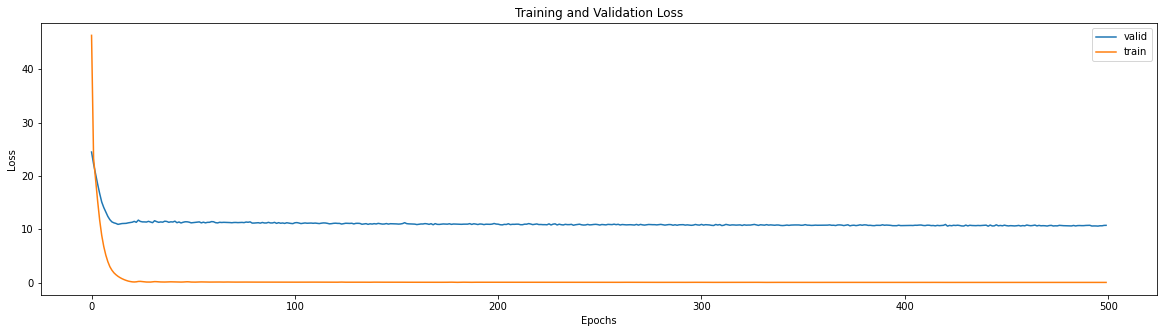

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [31]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 3.1440


In [69]:
#

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 364)
        self.fc2 = nn.Linear(364, 182)
        self.fc3 = nn.Linear(182, 91)
        self.fc4 = nn.Linear(91, 3)

        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        # x = F.leaky_relu(x)
        # x = self.fc5(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=364, bias=True)
  (fc2): Linear(in_features=364, out_features=182, bias=True)
  (fc3): Linear(in_features=182, out_features=91, bias=True)
  (fc4): Linear(in_features=91, out_features=3, bias=True)
)


In [4]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

349079

In [71]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()
epochs = epochs

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 43.8439
====> Test set loss: 24.7513
====> Epoch: 2 loss: 22.7750
====> Test set loss: 22.3718
====> Epoch: 3 loss: 17.5295
====> Test set loss: 19.2776
====> Epoch: 4 loss: 12.5472
====> Test set loss: 16.7139
====> Epoch: 5 loss: 8.6386
====> Test set loss: 15.5457
====> Epoch: 6 loss: 5.9462
====> Test set loss: 14.0366
====> Epoch: 7 loss: 4.0308
====> Test set loss: 12.7485
====> Epoch: 8 loss: 2.7058
====> Test set loss: 12.3735
====> Epoch: 9 loss: 1.9154
====> Test set loss: 11.8467
====> Epoch: 10 loss: 1.3563
====> Test set loss: 11.6345
====> Epoch: 11 loss: 0.9619
====> Test set loss: 11.6208
====> Epoch: 12 loss: 0.6509
====> Test set loss: 11.6767
====> Epoch: 13 loss: 0.4391
====> Test set loss: 11.7582
====> Epoch: 14 loss: 0.2845
====> Test set loss: 11.6964
====> Epoch: 15 loss: 0.1846
====> Test set loss: 11.7698
====> Epoch: 16 loss: 0.1279
====> Test set loss: 11.7745
====> Epoch: 17 loss: 0.1368
====> Test set loss: 11.8706
====> Epoch: 18 los

In [72]:
y4 = y_pred

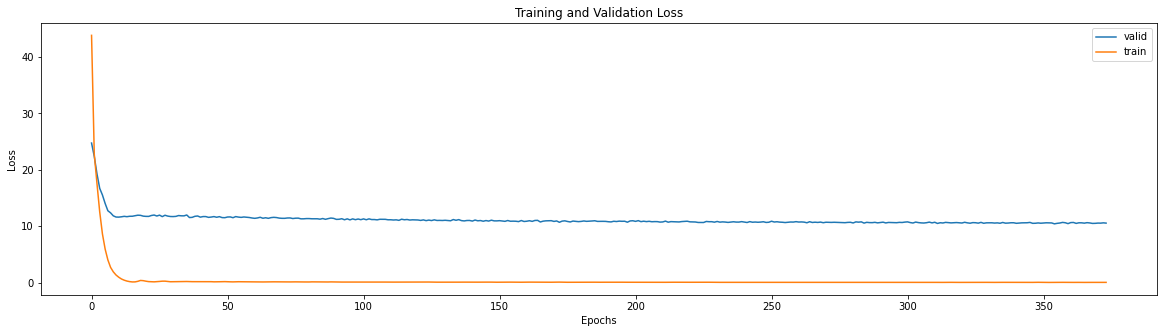

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [74]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 3.1349


In [ ]:
#

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(729, 364)
        self.fc2 = nn.Linear(364, 182)
        self.fc3 = nn.Linear(182, 91)
        self.fc4 = nn.Linear(91, 45)
        self.fc5 = nn.Linear(45, 3)

        #nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)
        #nn.init.xavier_uniform_(self.fc5.weight)
        #nn.init.xavier_uniform_(self.fc6.weight)
        #nn.init.xavier_uniform_(self.fc7.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 729))
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        # x = F.leaky_relu(x)
        # x = self.fc6(x)
        # x = F.leaky_relu(x)
        
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)

torch.manual_seed(42)
model = DNN().cuda()
model.apply(weights_init)
print(model)

DNN(
  (fc1): Linear(in_features=729, out_features=364, bias=True)
  (fc2): Linear(in_features=364, out_features=182, bias=True)
  (fc3): Linear(in_features=182, out_features=91, bias=True)
  (fc4): Linear(in_features=91, out_features=45, bias=True)
  (fc5): Linear(in_features=45, out_features=3, bias=True)
)


In [21]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

353081

In [22]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.MSELoss()
epochs = 500

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 45.1038
====> Test set loss: 25.2175
====> Epoch: 2 loss: 22.6731
====> Test set loss: 22.2429
====> Epoch: 3 loss: 16.5611
====> Test set loss: 19.4697
====> Epoch: 4 loss: 11.0210
====> Test set loss: 17.0368
====> Epoch: 5 loss: 6.9176
====> Test set loss: 14.9611
====> Epoch: 6 loss: 4.2835
====> Test set loss: 13.9351
====> Epoch: 7 loss: 2.7719
====> Test set loss: 13.0586
====> Epoch: 8 loss: 1.8763
====> Test set loss: 12.7011
====> Epoch: 9 loss: 1.3123
====> Test set loss: 12.7341
====> Epoch: 10 loss: 0.9314
====> Test set loss: 12.7509
====> Epoch: 11 loss: 0.6311
====> Test set loss: 12.6601
====> Epoch: 12 loss: 0.4202
====> Test set loss: 12.7045
====> Epoch: 13 loss: 0.3039
====> Test set loss: 12.6758
====> Epoch: 14 loss: 0.2529
====> Test set loss: 12.5784
====> Epoch: 15 loss: 0.3119
====> Test set loss: 12.9973
====> Epoch: 16 loss: 0.4970
====> Test set loss: 12.6935
====> Epoch: 17 loss: 0.5396
====> Test set loss: 12.6682
====> Epoch: 18 los

KeyboardInterrupt: ignored

In [23]:
y5 = y_pred

NameError: ignored

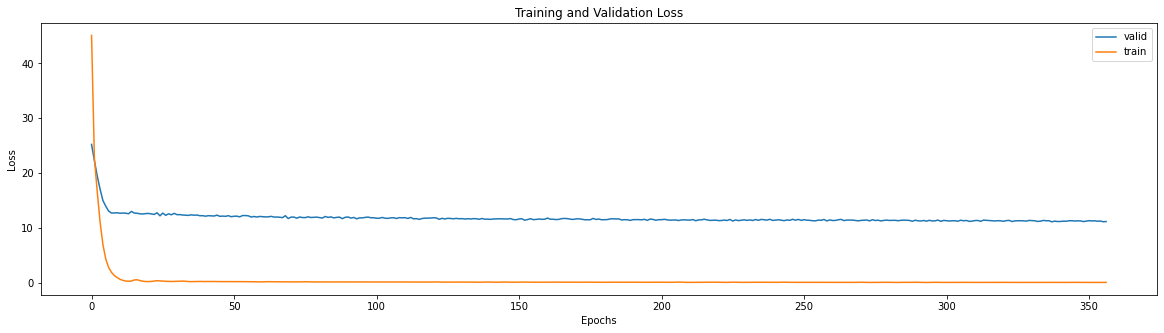

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [25]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 3.2243
